In [2]:
import numpy as np
import torch

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm

from alogcv.diagonal import diagonal
import linops as lo

from tqdm import tqdm

In [19]:
torch.manual_seed(0)
n0 = 100
p0 = 50
scale = 50
n_trials = 10

def generate_data(n, p, k_sparse=None):

    if k_sparse is None:
        k_sparse = p

    X = torch.randn(n, p) * torch.sqrt(torch.rand(n, 1) * 2)

    beta = torch.zeros(p)
    beta[:k_sparse] = torch.randn(k_sparse) / np.sqrt(k_sparse)

    y = X @ beta + torch.randn(n)
    return X, y, beta

def get_ridge_H(X, lamda):
    n, p = X.shape
    H = X @ torch.linalg.solve(X.T @ X + n * lamda * torch.eye(p), X.T)
    return lo.aslinearoperator(torch.eye(n) - H)
    # return lo.aslinearoperator(H)

def diag_rademacher(A, m):
    n = A.shape[0]
    V = (torch.randint(0, 2, (n, m)) * 2 - 1).float()
    AV = A @ V
    return (AV * V).mean(dim=1)

def diag_ortho(A, m):
    n = A.shape[0]
    V = (torch.randint(0, 2, (n, m)) * 2 - 1).float()
    Q, _ = torch.qr(V, some=True)
    # Q = torch.randn(n, m)
    Q /= torch.norm(Q, dim=1, keepdim=True)
    AQ = A @ Q
    return (AQ * Q).sum(dim=1)

def diagpp(A, m):
    n = A.shape[0]
    m1 = m // 3
    R = (torch.randint(0, 2, (n, m1)) * 2 - 1).float()
    AR = A @ R
    Q, _ = torch.qr(AR, some=True)
    AQ = A @ Q
    V = (torch.randint(0, 2, (n, m1)) * 2 - 1).float()
    AV = A @ V
    QTV = Q.T @ V
    A_ImQQ_V = AV - AQ @ QTV
    d = ((A_ImQQ_V - Q @ (Q.T @ A_ImQQ_V)) * V).mean(dim=1)
    return torch.diag(Q @ (Q.T @ AQ) @ Q.T) + d

n = n0 * scale
p = p0 * scale
X, y, beta = generate_data(n, p)
lamda = 0.01
H = get_ridge_H(X, lamda)
y_hat = H @ y
r = y - y_hat
h = torch.diag(H @ torch.eye(n))

# ms = torch.tensor([10, 20, 30, 40, 50, 60, 70, 80, 90]) * scale * 2
# ms = torch.tensor([20, 40, 60, 80, 100, 120]) * scale
ms = torch.tensor([1, 10, 100])

h_hats = torch.zeros((len(ms), n_trials, n))
h_hats_rad = torch.zeros((len(ms), n_trials, n))
h_hats_ortho = torch.zeros((len(ms), n_trials, n))
h_hats_pp = torch.zeros((len(ms), n_trials, n))

for i, m in enumerate(ms):
    for t in tqdm(range(n_trials), desc=f"m={m}"):
        h_hats[i, t, :] = lo.diag.xdiag(H, m)
        h_hats_rad[i, t, :] = diag_rademacher(H, m)
        h_hats_ortho[i, t, :] = diag_ortho(H, m)
        h_hats_pp[i, t, :] = diagpp(H, m)

m=100: 100%|██████████| 10/10 [00:02<00:00,  4.85it/s]


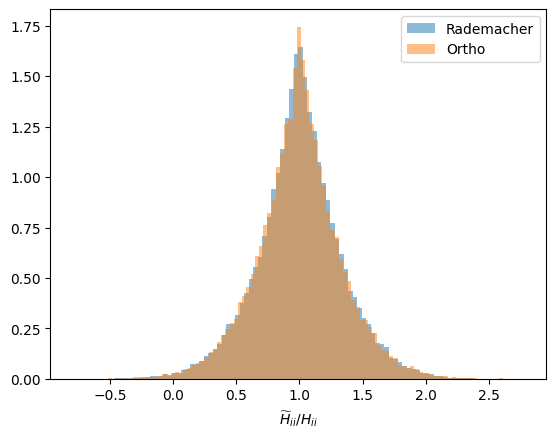

(tensor(10), 5000)

In [25]:
h_bcast = h.reshape(1, 1, -1)

i = 1
# plt.hist((h_hats[i, :, :] / h_bcast).flatten(), bins=100, alpha=0.5, density=True, label="Xdiag")
plt.hist((h_hats_rad[i, :, :] / h_bcast).flatten(), bins=100, alpha=0.5, density=True, label="Rademacher")
plt.hist((h_hats_ortho[i, :, :] / h_bcast).flatten(), bins=100, alpha=0.5, density=True, label="Ortho")
# plt.hist((h_hats_pp[i, :, :] / h_bcast).flatten(), bins=100, alpha=0.5, density=True, label="Diag++")
plt.legend()
plt.xlabel((r"$\widetilde{H}_{ii} / H_{ii}$"))
plt.show()

ms[i], n